# EasyVVUQ execution on HPC machines with QCG-PilotJob

**Author**: Bartosz Bosak, PSNC (bbosak@man.poznan.pl)

This tutorial is an extension of the EasyVVUQ basic tutorial available [here](https://mybinder.org/v2/gh/UCL-CCS/EasyVVUQ/a6852d6c5ba36f15579e601d7a8d074505f31084?filepath=tutorials%2Fbasic_tutorial.ipynb) to present how [QCG-PilotJob](https://github.com/vecma-project/QCG-PilotJob) can be used for HPC execution of the EasyVVUQ workflow. 

Since for many VVUQ scenarios there are a lot of calculations required, in terms of both the number of model executions and the computational requirements of a single execution, usage of large scale resources may be necessary. To this end and to enable efficient and flexible execution of demanding parts of EasyVVUQ workflow on HPC machines, EasyVVUQ has been integrated with the QCG-PilotJob tool. 

We assume that you are already familiar with the idea of the basic tutorial, thus here we don't go into the conceptual detials of the presented scenario and concentrate on the usage of QCG-PilotJob system only. 

In this example we present the same sensitivity analysis scenario of a model of vertical deflection of a tube as was used in the basic tutorial.  This is a relatively simple application that takes a JSON file with several parameters as an input and genenerates a JSON file as an output. The sets of input paramaeters are generated accordingly with the selected distributions and then, for each set, the model needs to be run, and finally the results of such executions need to be analysed. 

## Campaign configuration

The EasyVVUQ workflow that enables paralell execution with QCG-PilotJob is only slightly different that the basic workflow. The changes are in a few places only, so the majority of code can be simply inherited from the basic tutorial. We don't describe this inherited code in details, but rather focus on a new elements. 

At the beginning we import a few libraries. Since QCG-PilotJob is already integrated into EasyVVUQ, we don't need to import anything specific for this library:

In [1]:
import os
import easyvvuq as uq
import chaospy as cp
import matplotlib.pyplot as plt

There are also no differences in the initial configuration of the EasyVVUQ. The first thing is declaration of parameters for the simulation:

In [2]:
params = {
    "F": {"type": "float", "default": 1.0}, 
    "L": {"type": "float", "default": 1.5}, 
    "a": {"type": "float", "min": 0.7, "max": 1.2, "default": 1.0}, 
    "D": {"type": "float", "min": 0.75, "max": 0.85, "default": 0.8},
    "d": {"type": "float", "default": 0.1},
    "E": {"type": "float", "default": 200000},
    "outfile": {"type": "string", "default": "output.json"}
}

In the next step we define encoder and decoder that will be used to convert generated input parameters to the form of acceptable by the application, and an output from the application back to the form supported by EasyVVUQ, respectively. Since our application consumes and produces JSON files, we are able to employ predefined classes. For more advanced use-cases, more sophisticated custom encoders and decoders can be used. 

In [3]:
encoder = uq.encoders.GenericEncoder(template_fname='beam.template', delimiter='$', target_filename='input.json')
decoder = uq.decoders.JSONDecoder(target_filename='output.json', output_columns=['g1'])

The first update to the basic workflow is associated with the Campaign object. Campaign is the central entity that takes care of data management and data flow within EasyVVUQ. In order to use QCG-PilotJob, we can't use the basic version of the Campaing class, but its ammended version, called CampaignQCGPJ. 

In [4]:
campaign = uq.CampaignQCGPJ(name='beam', params=params, encoder=encoder, decoder=decoder)

## Samples preparation

In the next two steps we follow the basic tutorial. Firstly we define distributions for the selected uncertain parameters:

In [5]:
vary = {
    "F": cp.Normal(1, 0.1),
    "L": cp.Normal(1.5, 0.01),
    "a": cp.Uniform(0.7, 1.2),
    "D": cp.Triangle(0.75, 0.8, 0.85)
}

Once we do so, we set-up a sampler for our varying parameters. In this case we use Stochastic Collocation sampler with polynomial order equal to 3. 

In [6]:
campaign.set_sampler(uq.sampling.SCSampler(vary=vary, polynomial_order=3))

In order to prepare data for execution with QCG-PilotJob, we need now to invoke two method on the campaign. The `draw_samples()` method generates samples, the `populate_runs_dir()` method prepares input data for the application using the defined encoder. 

In [7]:
campaign.draw_samples()
campaign.populate_runs_dir()

['Run_1',
 'Run_2',
 'Run_3',
 'Run_4',
 'Run_5',
 'Run_6',
 'Run_7',
 'Run_8',
 'Run_9',
 'Run_10',
 'Run_11',
 'Run_12',
 'Run_13',
 'Run_14',
 'Run_15',
 'Run_16',
 'Run_17',
 'Run_18',
 'Run_19',
 'Run_20',
 'Run_21',
 'Run_22',
 'Run_23',
 'Run_24',
 'Run_25',
 'Run_26',
 'Run_27',
 'Run_28',
 'Run_29',
 'Run_30',
 'Run_31',
 'Run_32',
 'Run_33',
 'Run_34',
 'Run_35',
 'Run_36',
 'Run_37',
 'Run_38',
 'Run_39',
 'Run_40',
 'Run_41',
 'Run_42',
 'Run_43',
 'Run_44',
 'Run_45',
 'Run_46',
 'Run_47',
 'Run_48',
 'Run_49',
 'Run_50',
 'Run_51',
 'Run_52',
 'Run_53',
 'Run_54',
 'Run_55',
 'Run_56',
 'Run_57',
 'Run_58',
 'Run_59',
 'Run_60',
 'Run_61',
 'Run_62',
 'Run_63',
 'Run_64',
 'Run_65',
 'Run_66',
 'Run_67',
 'Run_68',
 'Run_69',
 'Run_70',
 'Run_71',
 'Run_72',
 'Run_73',
 'Run_74',
 'Run_75',
 'Run_76',
 'Run_77',
 'Run_78',
 'Run_79',
 'Run_80',
 'Run_81',
 'Run_82',
 'Run_83',
 'Run_84',
 'Run_85',
 'Run_86',
 'Run_87',
 'Run_88',
 'Run_89',
 'Run_90',
 'Run_91',
 'Run_92

## Execution with QCG-PilotJob 

Now we can go to the essential code needed for the executions of our model with QCG-PilotJob. At the beginning we define the command for the model execution. Please note we provide the full path to the application and the name of an input file. 

In [8]:
cmd = f"{os.getcwd()}/beam input.json"

The next step is to create the QCG-PilotJob manager instance. We can make it with a helper method provided by an object of `uq.pools.qcgpj.QCGPJ` class. This method can be executed without any parameters. In such a case QCG-PilotJob establishes number of available resources based on the discovered environment configuration. If QCG-PilotJob is run on a cluster, the resources would be defined based on the environment set by SLURM. In our tutorial however, QCG-PilotJob is executed in a virtual/local environment. In such circumstances the number of resources (cores) are taken directly from `/proc/cpuinfo`. 

In [9]:
qcgpj_manager = uq.pools.qcgpj.QCGPJ().create_manager()

**Note:** the `create_manager()` method accepts a few optional parameters. The `resources` parameter may be particularly useful for local tests of QCG-PilotJob. It allows to define virtual resources and arbitrarly set their number, so QCG-PilotJob can mimic more complex execution scenarios. 

Once `qcgpj_manager` instance is ready, we need to define dedicated `ExecuteQCGPJ` action for execution of models within it. The `task_requirements` parameter for the action's constructor allows to specify how many resources a single task should be executed onto. Here we assume that a task will take a single core only, but it can be changed if more resources (or virtual resources) are available. 

In [10]:
qcgpj_action = uq.actions.ExecuteQCGPJ(qcgpj_manager, cmd, task_requirements=uq.pools.qcgpj.TaskRequirements(cores=1))

For the actual execution, we employ the `apply_for_each_run_dir()` method available in the campaign object. The method takes `ExecuteQCGPJ` action and QCG-PilotJob manager  as parameters. 

In [11]:
campaign.apply_for_each_run_dir(
    qcgpj_action,
    qcgpj_manager
)

Now we just should finalize the QCG-PilotJob manager with the `finish()` method. 

In [12]:
qcgpj_manager.finish()

The execution of this method also concludes the QCG-PilotJob specific part of the code. At this moment we can follow the original example. 

## Analysis

We invoke `analyse()` method, which, depending on a selected sampling method, generates adequate analysis results. 

In [13]:
results = campaign.analyse(qoi_cols=['g1'])

Finally we can display the results. For example we can plot Sobols in a treemap format:

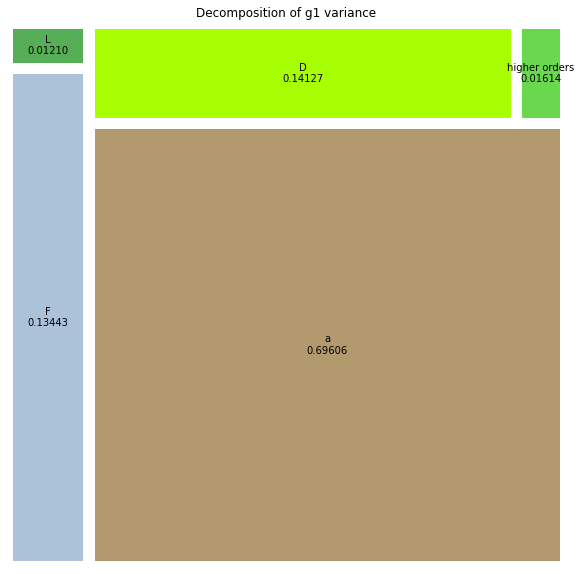

In [14]:
results.plot_sobols_treemap('g1', figsize=(10, 10))
plt.axis('off');

Alternatively you can get the Sobol index values using the method call below.

In [15]:
results.sobols_first()

{'g1': {'F': array([0.13443022]),
  'L': array([0.01209975]),
  'a': array([0.69605713]),
  'D': array([0.14127148])}}

## Further steps

In this tutorial we have presented a basic way how QCG-PilotJob can be used for HPC execution of evaluations of models in EasyVVUQ. If this embedded mechanism is not sufficient, VECMAtk provides also more advanced library, called [EQI](https://github.com/vecma-project/easyvvuq-qcgpj). EQI concentrates on most optimal QCG-PilotJob usage schemes and although it is less flexible, it can provide better performance for computationally demanding scenarios. 